In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn.objects as so
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

### Reading the Dataset

In [2]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/aclImdb/')

In [3]:
tr_d = text_dataset_from_directory( w_dir / 'train' )
va_d = text_dataset_from_directory( w_dir / 'validation' )
te_d = text_dataset_from_directory( w_dir / 'test' )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# getting multi-hot bigram
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode='multi_hot'
)

In [5]:
text_only = tr_d.map( lambda x, y: x )

text_vectorization.adapt( text_only )

In [6]:
tr_d_2gram = tr_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
va_d_2gram = va_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
te_d_2gram = te_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
tr_d_2gram = tr_d_2gram.prefetch(buffer_size=tf.data.AUTOTUNE)
va_d_2gram = va_d_2gram.prefetch(buffer_size=tf.data.AUTOTUNE)
te_d_2gram = te_d_2gram.prefetch(buffer_size=tf.data.AUTOTUNE)

### The model

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
with strategy.scope():
    inputs = keras.Input(shape=(20000,))
    
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'multi_hot_bigram.keras',
        save_best_only=True,
        monitor='accuracy'
    ),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d_2gram.cache(),
    epochs=43,
    validation_data=va_d_2gram.cache(),
    callbacks=callbacks
)

Epoch 1/43
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

### Testing the model

In [11]:
test_model = keras.models.load_model('multi_hot_bigram.keras')

In [12]:
print(f"Test Accuracy: {test_model.evaluate( te_d_2gram )[1]:.3f}")

782/782 [==============================] - 2s 2ms/step - loss: 0.6898 - accuracy: 0.8739
Test Accuracy: 0.874


### Ploting the learning curves

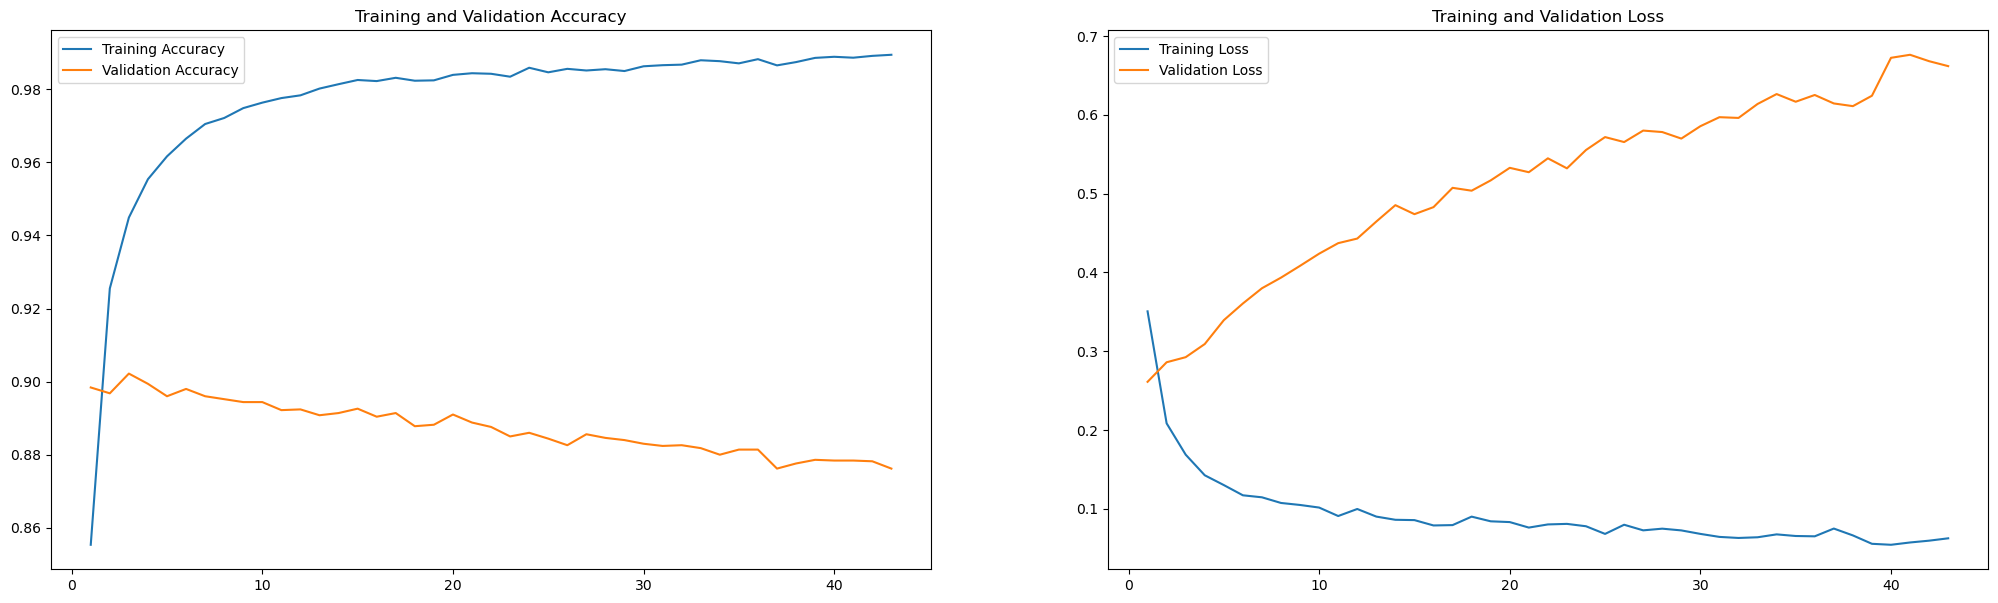

In [15]:
accuracy = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range( 1, len( accuracy ) + 1 )

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_accu, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend();